# Script: Correlation Analysis
Author: Alyde Bles  
Student Number: 2826862  
Date: 31/12/2024

This script calculates the correlation between Niño 3.4 SST anomalies and regional rolling anomalies for SST, wind stress, and thermocline depth. It identifies the top 10 regions per lag that show the strongest correlation with the Niño 3.4 region. Additionally, two plots are generated: one to visualize the size of the regions that are tested and another to show  correlations.

---

Table of Contents

1. [Packages](#Packages)  

2. [SST Analysis](#SST-Analysis)
   Identification of the top 10 regions per lag for SST with the highest correlation to the Niño 3.4 region.  

3. [Zonal Wind Stress Analysis](#Zonal-Wind-Stress-Analysis) 
   Identification of the top 10 regions per lag for zonal wind stress with the highest correlation to the Niño 3.4 region.  

4. [Thermocline Depth Analysis](#Thermocline-Depth-Analysis)  
   Identification of the top 10 regions per lag for thermocline depth with the highest correlation to the Niño 3.4 region.  

5. [Visualisation](#Visualisation)  
   - Region Visualisation: Displays the geographical size of the top regions.  
   - Correlation Plot: Shows the identified regions per variable per lag. 

## Packages

In [1]:
# Importing necessary libraries
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import netCDF4 as nc
from datetime import datetime
import sys, os
import urllib.request as opener
import xarray as xr
import statsmodels.api as sm
import zipfile
import cftime
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import pearsonr
import zipfile
import tempfile
from matplotlib.patches import Rectangle

import matplotlib.gridspec as gridspec

## SST Analysis

In [2]:
# This script calculates correlations between Niño 3.4 SST anomalies and regional rolling SST anomalies
# for different lags. It uses sliding windows to process regions within a larger area and outputs the
# correlations for all regions and lags.

# File path to the NetCDF file containing SST anomalies and rolling anomalies
file_path_with_anomalies = "Data/Data Process/sst_with_anomalies.nc"

try:
    # Open the NetCDF file
    with nc.Dataset(file_path_with_anomalies, 'r') as ncfile:
        # Load latitude, longitude, time, SST rolling anomalies, and SST anomalies
        latitudes = ncfile.variables['lat'][:]
        longitudes = ncfile.variables['lon'][:]
        times = ncfile.variables['time'][:]
        sst_rolling_anomalies = ncfile.variables['sst_rolling_anomaly'][:]
        sst_anomalies = ncfile.variables['sst_anomaly'][:]

        # Get the time units and convert time to datetime format
        time_units = ncfile.variables['time'].units
        time_dates = nc.num2date(times, units=time_units)

        # Filter time for valid range and convert to pandas Timestamp
        valid_times = [
            pd.Timestamp(time.year, time.month, time.day) if isinstance(time, (cftime.DatetimeGregorian, cftime.DatetimeProlepticGregorian)) else time
            for time in time_dates if time.year >= 1949
        ]

        # Determine the start index for valid times
        start_index = list(time_dates).index(valid_times[0])
        print(f"Start index determined: {start_index}")

        # Define Niño 3.4 region
        nino_34 = {'lat_min': -5, 'lat_max': 5, 'lon_min': 190, 'lon_max': 240}
        lat_mask_nino34 = (latitudes >= nino_34['lat_min']) & (latitudes <= nino_34['lat_max'])
        lon_mask_nino34 = (longitudes >= nino_34['lon_min']) & (longitudes <= nino_34['lon_max'])

        # Calculate mean SST anomalies for Niño 3.4 region
        nino_34_anomalies = sst_anomalies[start_index:, lat_mask_nino34, :][:, :, lon_mask_nino34]
        nino_34_mean = np.nanmean(nino_34_anomalies, axis=(1, 2))
        print("Niño 3.4 mean anomalies calculated.")

        # Define parameters for correlation analysis
        max_lag = 24
        all_correlations = []

        # Define the larger region and sliding window settings
        region = {'lat_min': -30, 'lat_max': 30, 'lon_min': 120, 'lon_max': 285}
        window_size_lat = 10
        window_size_lon = 20
        step_size_lat = 5    # Latitude step size (degrees)
        step_size_lon = 10   # Longitude step size (degrees)

        # Loop through each sub-region in the larger region
        for lat_start in np.arange(region['lat_min'], region['lat_max'] - window_size_lat + 1, step_size_lat):
            for lon_start in np.arange(region['lon_min'], region['lon_max'] - window_size_lon + 1, step_size_lon):
                # Calculate the boundaries for the current window
                lat_end = lat_start + window_size_lat
                lon_end = lon_start + window_size_lon

                # Skip if the window overlaps with the Niño 3.4 region
                if not (lat_start >= nino_34['lat_min'] and lat_end <= nino_34['lat_max'] and
                        lon_start >= nino_34['lon_min'] and lon_end <= nino_34['lon_max']):
                    # Create masks for the current window
                    lat_mask = (latitudes >= lat_start) & (latitudes < lat_end)
                    lon_mask = (longitudes >= lon_start) & (longitudes < lon_end)

                    # Extract mean rolling SST anomalies for the window
                    sst_window = sst_rolling_anomalies[start_index:, lat_mask, :][:, :, lon_mask]
                    sst_window_mean = np.nanmean(sst_window, axis=(1, 2))
                    sst_window_mean = np.nan_to_num(sst_window_mean, nan=0, posinf=0, neginf=0)

                    # Calculate correlations for each lag
                    for lag in range(1, max_lag + 1):  # Skip lag 0
                        if lag < len(nino_34_mean):
                            sst_window_lag = sst_window_mean[:-lag]  # SST data from 'lag' months ago
                            current_nino_34 = nino_34_mean[lag:]  # Current Niño 3.4 data
                            corr, _ = pearsonr(sst_window_lag, current_nino_34)
                            all_correlations.append({
                                'lat_start': lat_start,
                                'lat_end': lat_end,
                                'lon_start': lon_start,
                                'lon_end': lon_end,
                                'lag': lag,
                                'correlation': abs(corr)
                            })
                            print(f"Correlation at lag {lag} for region ({lat_start} - {lat_end}, {lon_start} - {lon_end}) calculated: {corr}")

        # Save all correlations to a DataFrame
        print(f"Total correlations calculated: {len(all_correlations)}")
        all_correlations_df_sst_regions = pd.DataFrame(all_correlations)

except Exception as e:
    # Handle errors during processing
    print(f"Error processing data: {e}")

Start index determined: 1140
Niño 3.4 mean anomalies calculated.
Correlation at lag 1 for region (-30 - -20, 120 - 140) calculated: nan
Correlation at lag 2 for region (-30 - -20, 120 - 140) calculated: nan
Correlation at lag 3 for region (-30 - -20, 120 - 140) calculated: nan
Correlation at lag 4 for region (-30 - -20, 120 - 140) calculated: nan
Correlation at lag 5 for region (-30 - -20, 120 - 140) calculated: nan
Correlation at lag 6 for region (-30 - -20, 120 - 140) calculated: nan
Correlation at lag 7 for region (-30 - -20, 120 - 140) calculated: nan
Correlation at lag 8 for region (-30 - -20, 120 - 140) calculated: nan
Correlation at lag 9 for region (-30 - -20, 120 - 140) calculated: nan
Correlation at lag 10 for region (-30 - -20, 120 - 140) calculated: nan
Correlation at lag 11 for region (-30 - -20, 120 - 140) calculated: nan
Correlation at lag 12 for region (-30 - -20, 120 - 140) calculated: nan
Correlation at lag 13 for region (-30 - -20, 120 - 140) calculated: nan
Correlat

/var/folders/3f/nnz8vtyn1n1c7tqy95wr479w0000gn/T/ipykernel_10289/1220345512.py:69: RuntimeWarning: Mean of empty slice
  sst_window_mean = np.nanmean(sst_window, axis=(1, 2))
/var/folders/3f/nnz8vtyn1n1c7tqy95wr479w0000gn/T/ipykernel_10289/1220345512.py:77: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(sst_window_lag, current_nino_34)


Correlation at lag 9 for region (-30 - -20, 220 - 240) calculated: 0.07090923482906583
Correlation at lag 10 for region (-30 - -20, 220 - 240) calculated: 0.0932253126155372
Correlation at lag 11 for region (-30 - -20, 220 - 240) calculated: 0.1072884222656657
Correlation at lag 12 for region (-30 - -20, 220 - 240) calculated: 0.11220906132181126
Correlation at lag 13 for region (-30 - -20, 220 - 240) calculated: 0.11096341332985352
Correlation at lag 14 for region (-30 - -20, 220 - 240) calculated: 0.10764844346151488
Correlation at lag 15 for region (-30 - -20, 220 - 240) calculated: 0.10449944923516963
Correlation at lag 16 for region (-30 - -20, 220 - 240) calculated: 0.09890811192069345
Correlation at lag 17 for region (-30 - -20, 220 - 240) calculated: 0.09032146374980773
Correlation at lag 18 for region (-30 - -20, 220 - 240) calculated: 0.08100171028518788
Correlation at lag 19 for region (-30 - -20, 220 - 240) calculated: 0.07191679367384679
Correlation at lag 20 for region (-

In [3]:
# Ensure the output directory exists
output_directory = "Data/Data Top/"
os.makedirs(output_directory, exist_ok=True)

# Group by 'lag' and get the top 20 correlations for each lag
top_10_per_lag_sst = all_correlations_df_sst_regions.groupby('lag').apply(
    lambda x: x.nlargest(10, 'correlation')
).reset_index(drop=True)

# Define file paths for the dataset
file_path_with_anomalies = "Data/Data Process/sst_with_anomalies.nc"

try:
    # Open the NetCDF file
    with nc.Dataset(file_path_with_anomalies, 'r') as ncfile:
        # Extract latitudes, longitudes, times, and SST anomaly data
        latitudes = ncfile.variables['lat'][:]
        longitudes = ncfile.variables['lon'][:]
        times = ncfile.variables['time'][:]
        sst_anomalies = ncfile.variables['sst_rolling_anomaly'][:]

        # Convert times to datetime
        print("Converting time to datetime objects...")
        time_units = ncfile.variables['time'].units
        time_dates = nc.num2date(times, units=time_units)
        valid_times = [
            pd.Timestamp(time.year, time.month, time.day)
            for time in time_dates if time.year >= 1949
        ]
        start_index = list(time_dates).index(valid_times[0])

        files_saved = []

        print("Processing regions for each lag...")
        for lag, group in top_10_per_lag_sst.groupby('lag'):
            # Initialize dictionary to store average SST anomalies for the top 20 regions at this lag
            lag_data = {"time": valid_times}
            
            for _, row in group.iterrows():
                lat_start, lat_end = row['lat_start'], row['lat_end']
                lon_start, lon_end = row['lon_start'], row['lon_end']

                # Get latitude and longitude masks for the current region
                lat_mask = (latitudes >= lat_start) & (latitudes < lat_end)
                lon_mask = (longitudes >= lon_start) & (longitudes < lon_end)

                # Extract SST anomaly values for the current region
                sst_window_anomalies = sst_anomalies[start_index:, lat_mask, :][:, :, lon_mask]

                # Compute mean anomalies for the region
                if not np.ma.is_masked(sst_window_anomalies) and sst_window_anomalies.size > 0:
                    mean_anomaly = np.nanmean(sst_window_anomalies, axis=(1, 2))
                    mean_anomaly = np.nan_to_num(mean_anomaly, nan=0, posinf=0, neginf=0)


                    # Create column name using region boundaries
                    region_label = f"lat_{lat_start}-{lat_end}_lon_{lon_start}-{lon_end}"
                    lag_data[region_label] = mean_anomaly

            # Convert data to DataFrame and save for the current lag
            lag_df = pd.DataFrame(lag_data)
            lag_df.set_index("time", inplace=True)

            file_name = f"{output_directory}top_20_regions_averages_lag_{lag}_sst.csv"
            lag_df.to_csv(file_name)
            files_saved.append(file_name)
            print(f"Saved top 20 region averages for lag {lag} to '{file_name}'.")

except Exception as e:
    print(f"Error: {e}")



/var/folders/3f/nnz8vtyn1n1c7tqy95wr479w0000gn/T/ipykernel_10289/2287337146.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_10_per_lag_sst = all_correlations_df_sst_regions.groupby('lag').apply(


Converting time to datetime objects...
Processing regions for each lag...
Saved top 20 region averages for lag 1 to 'Data/Data Top/top_20_regions_averages_lag_1_sst.csv'.
Saved top 20 region averages for lag 2 to 'Data/Data Top/top_20_regions_averages_lag_2_sst.csv'.
Saved top 20 region averages for lag 3 to 'Data/Data Top/top_20_regions_averages_lag_3_sst.csv'.
Saved top 20 region averages for lag 4 to 'Data/Data Top/top_20_regions_averages_lag_4_sst.csv'.
Saved top 20 region averages for lag 5 to 'Data/Data Top/top_20_regions_averages_lag_5_sst.csv'.
Saved top 20 region averages for lag 6 to 'Data/Data Top/top_20_regions_averages_lag_6_sst.csv'.
Saved top 20 region averages for lag 7 to 'Data/Data Top/top_20_regions_averages_lag_7_sst.csv'.
Saved top 20 region averages for lag 8 to 'Data/Data Top/top_20_regions_averages_lag_8_sst.csv'.
Saved top 20 region averages for lag 9 to 'Data/Data Top/top_20_regions_averages_lag_9_sst.csv'.
Saved top 20 region averages for lag 10 to 'Data/Data

## Zonal Wind Stress Analysis 

In [4]:
# This script calculates correlations between Niño 3.4 SST anomalies and regional rolling zonal wind stress anomalies
# for different lags. It uses sliding windows to process regions within a larger area and outputs the
# correlations for all regions and lags.

# Define file paths
file_path_sst_anomalies = "Data/Data Process/sst_with_anomalies.nc"
file_path_wind_stress_anomalies = "Data/Data Process/wind_stress_with_anomalies.nc"

try:
    # Open the SST anomalies NetCDF file
    with nc.Dataset(file_path_sst_anomalies, 'r') as sst_ncfile:
        # Extract data
        latitudes = sst_ncfile.variables['lat'][:]
        longitudes = sst_ncfile.variables['lon'][:]
        times = sst_ncfile.variables['time'][:]
        sst_anomalies = sst_ncfile.variables['sst_anomaly'][:]
        
        # Convert times to datetime objects
        time_dates = nc.num2date(times, sst_ncfile.variables['time'].units)
        valid_times = [pd.Timestamp(t.year, t.month, t.day) for t in time_dates if t.year >= 1949]
        start_index = list(time_dates).index(valid_times[0])
        
        # Extract Niño 3.4 region SST anomalies
        nino_34 = {'lat_min': -5, 'lat_max': 5, 'lon_min': 190, 'lon_max': 240}
        lat_mask_nino34 = (latitudes >= nino_34['lat_min']) & (latitudes <= nino_34['lat_max'])
        lon_mask_nino34 = (longitudes >= nino_34['lon_min']) & (longitudes <= nino_34['lon_max'])
        nino_34_anomalies = sst_anomalies[start_index:, lat_mask_nino34, :][:, :, lon_mask_nino34]
        nino_34_mean = np.nanmean(nino_34_anomalies, axis=(1, 2))

    # Open the wind stress anomalies NetCDF file
    with nc.Dataset(file_path_wind_stress_anomalies, 'r') as wind_ncfile:
        # Extract data
        wind_latitudes = wind_ncfile.variables['lat'][:]
        wind_longitudes = wind_ncfile.variables['lon'][:]
        wind_times = wind_ncfile.variables['time'][:]
        wind_stress = wind_ncfile.variables['uflx_rolling_anomaly'][:]
        
        # Convert wind stress times to datetime objects
        wind_time_dates = nc.num2date(wind_times, wind_ncfile.variables['time'].units)
        wind_valid_times = [pd.Timestamp(t.year, t.month, t.day) for t in wind_time_dates if t.year >= 1949]
        wind_start_index = list(wind_time_dates).index(wind_valid_times[0])
        
        # Define regions for analysis
        region = {'lat_min': -30, 'lat_max': 30, 'lon_min': 120, 'lon_max': 285}
        window_size_lat = 10
        window_size_lon = 20
        step_size_lat = 5     # Latitude step size (degrees)
        step_size_lon = 10   # Longitude step size (degrees)
        max_lag = 24

        # Analyze each region
        all_correlations = []
        for lat_start in np.arange(region['lat_min'], region['lat_max'] - window_size_lat + 1, step_size_lat):
            for lon_start in np.arange(region['lon_min'], region['lon_max'] - window_size_lon + 1, step_size_lon):
                lat_end = lat_start + window_size_lat
                lon_end = lon_start + window_size_lon
                
                lat_mask = (wind_latitudes >= lat_start) & (wind_latitudes < lat_end)
                lon_mask = (wind_longitudes >= lon_start) & (wind_longitudes < lon_end)
                regional_wind_stress = wind_stress[wind_start_index:, lat_mask, :][:, :, lon_mask]
                regional_wind_mean = np.nanmean(regional_wind_stress, axis=(1, 2))
                
                # Compute correlation for each lag
                for lag in range(1, max_lag + 1):
                    if lag < len(regional_wind_mean) and lag < len(nino_34_mean):
                        wind_lag = regional_wind_mean[:-lag]
                        nino_current = nino_34_mean[lag:]
                        corr, _ = pearsonr(wind_lag, nino_current)
                        all_correlations.append({
                                'lat_start': lat_start,
                                'lat_end': lat_end,
                                'lon_start': lon_start,
                                'lon_end': lon_end,
                                'lag': lag,
                                'correlation': abs(corr)
                        })
                        print(f"Correlation at lag {lag} calculated: {corr}")

        # Display all calculated correlations
        correlations_df_ws = pd.DataFrame(all_correlations)
        print(correlations_df_ws)

except Exception as e:
    print(f"Error processing data: {e}")

Correlation at lag 1 calculated: -0.010045175944638255
Correlation at lag 2 calculated: 0.005565694406680774
Correlation at lag 3 calculated: 0.008770863866482523
Correlation at lag 4 calculated: -0.0061756089151436145
Correlation at lag 5 calculated: -0.0371745682431407
Correlation at lag 6 calculated: -0.07732154988247134
Correlation at lag 7 calculated: -0.12031749069554559
Correlation at lag 8 calculated: -0.16564616049998315
Correlation at lag 9 calculated: -0.21142196228383345
Correlation at lag 10 calculated: -0.2530475847849678
Correlation at lag 11 calculated: -0.28648605624069673
Correlation at lag 12 calculated: -0.30602218161492584
Correlation at lag 13 calculated: -0.3085753250792329
Correlation at lag 14 calculated: -0.29577525216759937
Correlation at lag 15 calculated: -0.27102301899195214
Correlation at lag 16 calculated: -0.23760905400745985
Correlation at lag 17 calculated: -0.19848554775122845
Correlation at lag 18 calculated: -0.15569408125556228
Correlation at lag 

In [5]:
# Ensure the output directory exists
output_directory = "Data/Data Top/"
os.makedirs(output_directory, exist_ok=True)

# Group by 'lag' and get the top 20 correlations for each lag
top_10_per_lag_ws = correlations_df_ws.groupby('lag').apply(
    lambda x: x.nlargest(10, 'correlation')
).reset_index(drop=True)

# Define file paths for the dataset
file_path_with_anomalies_ws = "Data/Data Process/wind_stress_with_anomalies.nc"

try:
    # Open the NetCDF file
    with nc.Dataset(file_path_with_anomalies_ws, 'r') as ncfile:
        # Extract latitudes, longitudes, times, and SST anomaly data
        latitudes = ncfile.variables['lat'][:]
        longitudes = ncfile.variables['lon'][:]
        times = ncfile.variables['time'][:]
        ws_anomalies = ncfile.variables['uflx_rolling_anomaly'][:]

        # Convert times to datetime
        print("Converting time to datetime objects...")
        time_units = ncfile.variables['time'].units
        time_dates = nc.num2date(times, units=time_units)
        valid_times = [
            pd.Timestamp(time.year, time.month, time.day)
            for time in time_dates if time.year >= 1949
        ]
        start_index = list(time_dates).index(valid_times[0])

        files_saved = []

        print("Processing regions for each lag...")
        for lag, group in top_10_per_lag_ws.groupby('lag'):
            # Initialize dictionary to store average SST anomalies for the top 20 regions at this lag
            lag_data = {"time": valid_times}
            
            for _, row in group.iterrows():
                lat_start, lat_end = row['lat_start'], row['lat_end']
                lon_start, lon_end = row['lon_start'], row['lon_end']

                # Get latitude and longitude masks for the current region
                lat_mask = (latitudes >= lat_start) & (latitudes < lat_end)
                lon_mask = (longitudes >= lon_start) & (longitudes < lon_end)

                # Extract SST anomaly values for the current region
                ws_window_anomalies = ws_anomalies[start_index:, lat_mask, :][:, :, lon_mask]

                # Compute mean anomalies for the region
                if not np.ma.is_masked(ws_window_anomalies) and ws_window_anomalies.size > 0:
                    mean_anomaly = np.nanmean(ws_window_anomalies, axis=(1, 2))

                    # Create column name using region boundaries
                    region_label = f"lat_{lat_start}-{lat_end}_lon_{lon_start}-{lon_end}"
                    lag_data[region_label] = mean_anomaly

            # Convert data to DataFrame and save for the current lag
            lag_df = pd.DataFrame(lag_data)
            lag_df.set_index("time", inplace=True)

            file_name = f"{output_directory}top_20_regions_averages_lag_{lag}_ws.csv"
            lag_df.to_csv(file_name)
            files_saved.append(file_name)
            print(f"Saved top 20 region averages for lag {lag} to '{file_name}'.")

except Exception as e:
    print(f"Error: {e}")

/var/folders/3f/nnz8vtyn1n1c7tqy95wr479w0000gn/T/ipykernel_10289/1845636815.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_10_per_lag_ws = correlations_df_ws.groupby('lag').apply(


Converting time to datetime objects...
Processing regions for each lag...
Saved top 20 region averages for lag 1 to 'Data/Data Top/top_20_regions_averages_lag_1_ws.csv'.
Saved top 20 region averages for lag 2 to 'Data/Data Top/top_20_regions_averages_lag_2_ws.csv'.
Saved top 20 region averages for lag 3 to 'Data/Data Top/top_20_regions_averages_lag_3_ws.csv'.
Saved top 20 region averages for lag 4 to 'Data/Data Top/top_20_regions_averages_lag_4_ws.csv'.
Saved top 20 region averages for lag 5 to 'Data/Data Top/top_20_regions_averages_lag_5_ws.csv'.
Saved top 20 region averages for lag 6 to 'Data/Data Top/top_20_regions_averages_lag_6_ws.csv'.
Saved top 20 region averages for lag 7 to 'Data/Data Top/top_20_regions_averages_lag_7_ws.csv'.
Saved top 20 region averages for lag 8 to 'Data/Data Top/top_20_regions_averages_lag_8_ws.csv'.
Saved top 20 region averages for lag 9 to 'Data/Data Top/top_20_regions_averages_lag_9_ws.csv'.
Saved top 20 region averages for lag 10 to 'Data/Data Top/top_

## Thermocline Depth Analysis

In [6]:

# This script calculates correlations between Niño 3.4 SST anomalies and regional rolling thermocline depth anomalies
# for different lags. It uses sliding windows to process regions within a larger area and outputs the
# correlations for all regions and lags.
# Define Pacific Ocean region limits

lat_bounds = (-30, 30)  # Latitude range for the Pacific
lon_bounds = (120, 285)  # Longitude range (120°E to 60°W converted to 0–360°)
window_size_lat = 10  # Latitude window size (degrees)
window_size_lon = 20  # Longitude window size (degrees)
step_size_lat = 5     # Latitude step size (degrees)
step_size_lon = 10     # Longitude step size (degrees)
max_lag = 24          # Maximum lag to evaluate

try:
    # Load SST anomalies using netCDF4
    print("Loading SST anomalies data...")
    sst_data = nc.Dataset("Data/Data Process/sst_with_anomalies.nc")
    latitudes = sst_data.variables["lat"][:]
    longitudes = sst_data.variables["lon"][:]
    times = sst_data.variables["time"][:]
    sst_anomalies = sst_data.variables["sst_anomaly"][:]

    # Convert times to datetime objects
    time_units = sst_data.variables["time"].units
    time_calendar = sst_data.variables["time"].calendar
    times_dt = nc.num2date(times, units=time_units, calendar=time_calendar)
    times_dt = pd.to_datetime([f"{time.year}-{time.month}-01" for time in times_dt])

    # Filter dates to match from 1950 to 2023
    idx = (times_dt >= "1950-01-01") & (times_dt <= "2023-12-31")
    times_dt = times_dt[idx]
    sst_anomalies = sst_anomalies[idx, :, :]
    print("SST anomalies data loaded successfully.")

    # Load Z20 anomalies using xarray
    print("Loading Z20 anomalies data...")
    z20_ds = xr.open_dataset("Data/Data Process/z20_with_anomalies.nc")
    z20_anomaly = z20_ds["z20_depth_rolling_anomaly"].sel(time=slice("1950-01-01", "2023-12-31"))
    z20_anomaly = z20_anomaly.where(z20_anomaly <= 1e6, np.nan)  # Set values greater than 1e6 to NaN
    # Print the minimum, maximum, and the count of NaN values
    print("Min value:", z20_anomaly.min().values)
    print("Max value:", z20_anomaly.max().values)
    print("Count of NaN values:", z20_anomaly.isnull().sum().values)
    z20_anomaly["time"] = pd.to_datetime(z20_anomaly["time"].dt.strftime("%Y-%m-01"))
    print("Z20 anomalies data loaded successfully.")

    # Prepare for correlation calculations
    correlations = []
    print("Preparing for correlation calculations...")

    # Extract Nino 3.4 mean SST anomalies
    print("Extracting Nino 3.4 mean SST anomalies...")
    nino_34_mean = np.nanmean(
        sst_anomalies[:, (latitudes >= -5) & (latitudes <= 5), :][:, :, (longitudes >= 190) & (longitudes <= 240)],
        axis=(1, 2),
    )
    print("Nino 3.4 mean SST anomalies extracted.")

    # Process each sub-region in the larger region
    print("Processing each sub-region in the larger region...")
    for lat_start in np.arange(lat_bounds[0], lat_bounds[1] - window_size_lat + 1, step_size_lat):
        for lon_start in np.arange(lon_bounds[0], lon_bounds[1] - window_size_lon + 1, step_size_lon):
            lat_end = lat_start + window_size_lat
            lon_end = lon_start + window_size_lon
            print(f"Processing region from lat {lat_start} to {lat_end}, lon {lon_start} to {lon_end}...")

            # Select z20 data for current window
            z20_window = z20_anomaly.sel(lat=slice(lat_start, lat_end), lon=slice(lon_start, lon_end))

            z20_window_mean = z20_window.mean(dim=["lat", "lon"], skipna=True).values
             # Check if the region is valid (not all NaN values)
            if np.all(np.isnan(z20_window_mean)):
                print(f"Skipping region from lat {lat_start} to {lat_end}, lon {lon_start} to {lon_end} as it contains only NaN values.")
                continue  # Skip this region if it contains only NaN values

            z20_window_mean = np.nan_to_num(z20_window_mean, nan=0, posinf=0, neginf=0)  # Clean data
            z20_window_mean = np.where(z20_window_mean > 1e6, 0, z20_window_mean)  # Set large values to 0

            # Calculate correlations for each lag
            for lag in range(1, max_lag + 1):
                if lag <= len(z20_window_mean):
                    shifted_z20_mean = z20_window_mean[:-lag]  # Shift Z20 data
                    valid_nino_34 = nino_34_mean[lag:]  # Match Niño 3.4 data
                    correlation = pearsonr(shifted_z20_mean, valid_nino_34)[0]
                    correlations.append(
                        {
                            "lat_start": lat_start,
                            "lat_end": lat_end,
                            "lon_start": lon_start,
                            "lon_end": lon_end,
                            "lag": lag,
                            "correlation": abs(correlation),
                        }
                    )

    # Convert results to DataFrame
    correlation_df_z20 = pd.DataFrame(correlations)
    print("Final correlation data prepared:")
    print(correlation_df_z20)

except Exception as e:
    print(f"Error processing data: {e}")


Loading SST anomalies data...
SST anomalies data loaded successfully.
Loading Z20 anomalies data...
Min value: -316.6981506347656
Max value: 393.5444641113281
Count of NaN values: 38322766
Z20 anomalies data loaded successfully.
Preparing for correlation calculations...
Extracting Nino 3.4 mean SST anomalies...
Nino 3.4 mean SST anomalies extracted.
Processing each sub-region in the larger region...
Processing region from lat -30 to -20, lon 120 to 140...
Processing region from lat -30 to -20, lon 130 to 150...
Processing region from lat -30 to -20, lon 140 to 160...
Processing region from lat -30 to -20, lon 150 to 170...
Processing region from lat -30 to -20, lon 160 to 180...
Processing region from lat -30 to -20, lon 170 to 190...
Processing region from lat -30 to -20, lon 180 to 200...
Processing region from lat -30 to -20, lon 190 to 210...


/var/folders/3f/nnz8vtyn1n1c7tqy95wr479w0000gn/T/ipykernel_10289/3584133219.py:84: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation = pearsonr(shifted_z20_mean, valid_nino_34)[0]


Processing region from lat -30 to -20, lon 200 to 220...
Processing region from lat -30 to -20, lon 210 to 230...
Processing region from lat -30 to -20, lon 220 to 240...
Processing region from lat -30 to -20, lon 230 to 250...
Processing region from lat -30 to -20, lon 240 to 260...
Processing region from lat -30 to -20, lon 250 to 270...
Processing region from lat -30 to -20, lon 260 to 280...
Processing region from lat -25 to -15, lon 120 to 140...
Processing region from lat -25 to -15, lon 130 to 150...
Processing region from lat -25 to -15, lon 140 to 160...
Processing region from lat -25 to -15, lon 150 to 170...
Processing region from lat -25 to -15, lon 160 to 180...
Processing region from lat -25 to -15, lon 170 to 190...
Processing region from lat -25 to -15, lon 180 to 200...
Processing region from lat -25 to -15, lon 190 to 210...
Processing region from lat -25 to -15, lon 200 to 220...
Processing region from lat -25 to -15, lon 210 to 230...
Processing region from lat -25 

In [7]:
# Ensure the output directory exists
output_directory = "Data/Data Top/"
os.makedirs(output_directory, exist_ok=True)

# Group by 'lag' and get the top 20 correlations for each lag
top_10_per_lag_z20 = correlation_df_z20.groupby('lag').apply(
    lambda x: x.nlargest(10, 'correlation')
).reset_index(drop=True)

# Define file paths for the z20 dataset
file_path_with_anomalies_z20 = "Data/Data Process/z20_with_anomalies.nc"

try:
    print("Opening Z20 anomalies file...")
    # Open the z20 dataset with xarray
    z20_ds = xr.open_dataset(file_path_with_anomalies_z20)
    latitudes_z20 = z20_ds['lat'].values
    longitudes_z20 = z20_ds['lon'].values
    times_z20 = pd.to_datetime(z20_ds['time'].values)
    z20_anomalies = z20_ds['z20_depth_rolling_anomaly'].values

    # Convert times to start of the month for alignment
    valid_times = [
        time for time in times_z20 if time.year >= 1949
    ]
    start_index = times_z20.tolist().index(valid_times[0])

    files_saved = []

    print("Processing regions for each lag...")
    for lag, group in top_10_per_lag_z20.groupby('lag'):
        # Initialize dictionary to store average z20 anomalies for the top 20 regions at this lag
        lag_data = {"time": valid_times}
        
        for _, row in group.iterrows():
            lat_start, lat_end = row['lat_start'], row['lat_end']
            lon_start, lon_end = row['lon_start'], row['lon_end']

            # Get latitude and longitude masks for the current region
            lat_mask = (latitudes_z20 >= lat_start) & (latitudes_z20 < lat_end)
            lon_mask = (longitudes_z20 >= lon_start) & (longitudes_z20 < lon_end)

            # Extract z20 anomaly values for the current region
            z20_window_anomalies = z20_anomalies[start_index:, lat_mask, :][:, :, lon_mask]
            z20_window_anomalies[z20_window_anomalies > 10000] = 0
            z20_window_anomalies[z20_window_anomalies < -10000] = 0

            

            # Compute mean anomalies for the region
            if not np.ma.is_masked(z20_window_anomalies) and z20_window_anomalies.size > 0:
                mean_anomaly = np.nanmean(z20_window_anomalies, axis=(1, 2))

                # Create column name using region boundaries
                region_label = f"lat_{lat_start}-{lat_end}_lon_{lon_start}-{lon_end}"
                lag_data[region_label] = mean_anomaly

        # Convert data to DataFrame and save for the current lag
        lag_df = pd.DataFrame(lag_data)
        lag_df.set_index("time", inplace=True)

        file_name = f"{output_directory}top_20_regions_averages_lag_{lag}_z20.csv"
        lag_df.to_csv(file_name)
        files_saved.append(file_name)
        print(f"Saved top 20 region averages for lag {lag} to '{file_name}'.")

except Exception as e:
    print(f"Error: {e}")

/var/folders/3f/nnz8vtyn1n1c7tqy95wr479w0000gn/T/ipykernel_10289/2442651945.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_10_per_lag_z20 = correlation_df_z20.groupby('lag').apply(


Opening Z20 anomalies file...
Processing regions for each lag...
Saved top 20 region averages for lag 1 to 'Data/Data Top/top_20_regions_averages_lag_1_z20.csv'.
Saved top 20 region averages for lag 2 to 'Data/Data Top/top_20_regions_averages_lag_2_z20.csv'.
Saved top 20 region averages for lag 3 to 'Data/Data Top/top_20_regions_averages_lag_3_z20.csv'.
Saved top 20 region averages for lag 4 to 'Data/Data Top/top_20_regions_averages_lag_4_z20.csv'.
Saved top 20 region averages for lag 5 to 'Data/Data Top/top_20_regions_averages_lag_5_z20.csv'.
Saved top 20 region averages for lag 6 to 'Data/Data Top/top_20_regions_averages_lag_6_z20.csv'.
Saved top 20 region averages for lag 7 to 'Data/Data Top/top_20_regions_averages_lag_7_z20.csv'.
Saved top 20 region averages for lag 8 to 'Data/Data Top/top_20_regions_averages_lag_8_z20.csv'.
Saved top 20 region averages for lag 9 to 'Data/Data Top/top_20_regions_averages_lag_9_z20.csv'.
Saved top 20 region averages for lag 10 to 'Data/Data Top/top_

## Visualisation


### Plot 1

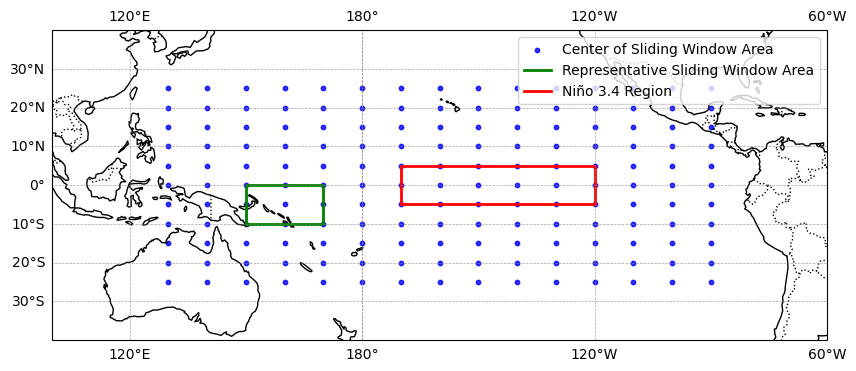

In [8]:
# Define sliding window parameters
window_size_lat = 10
window_size_lon = 20
step_size_lat = 5
step_size_lon = 10

# Define Niño 3.4 and larger region boundaries
nino_34 = {'lat_min': -5, 'lat_max': 5, 'lon_min': 190, 'lon_max': 240}
region = {'lat_min': -30, 'lat_max': 30, 'lon_min': 120, 'lon_max': 285}

# Create figure and axis
fig = plt.figure(figsize=(10, 8))
projection = ccrs.PlateCarree(central_longitude=180)
ax = plt.axes(projection=projection)
ax.set_extent([100, 300, -40, 40], crs=ccrs.PlateCarree())

# Add map features
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.7, linestyle='--')

# Iterate over the region with sliding windows to plot the centers of the windows
lat_start = region['lat_min']
lon_start = region['lon_min']

while lat_start + window_size_lat <= region['lat_max']:
    lon_start = region['lon_min']
    while lon_start + window_size_lon <= region['lon_max']:
        # Calculate center of the current window
        center_lat = lat_start + window_size_lat / 2
        center_lon = lon_start + window_size_lon / 2

        # Plot the center as a dot
        ax.scatter(center_lon, center_lat, color='blue', s=10, alpha=0.8, transform=ccrs.PlateCarree(), label='Center of Sliding Window Area' if (lat_start == region['lat_min'] and lon_start == region['lon_min']) else "")

        lon_start += step_size_lon
    lat_start += step_size_lat

# Draw one representative window for illustration purposes
rep_window_lat_min = -10
rep_window_lat_max = rep_window_lat_min + window_size_lat
rep_window_lon_min = 150
rep_window_lon_max = rep_window_lon_min + window_size_lon

rep_window_box = [
    [rep_window_lon_min, rep_window_lat_min],
    [rep_window_lon_min, rep_window_lat_max],
    [rep_window_lon_max, rep_window_lat_max],
    [rep_window_lon_max, rep_window_lat_min],
    [rep_window_lon_min, rep_window_lat_min]
]
rep_window_lon, rep_window_lat = zip(*rep_window_box)
ax.plot(rep_window_lon, rep_window_lat, color='green', linewidth=2, linestyle='-', transform=ccrs.PlateCarree(), label='Representative Sliding Window Area')

# Outline Niño 3.4 region
nino_34_box = [
    [nino_34['lon_min'], nino_34['lat_min']],
    [nino_34['lon_min'], nino_34['lat_max']],
    [nino_34['lon_max'], nino_34['lat_max']],
    [nino_34['lon_max'], nino_34['lat_min']],
    [nino_34['lon_min'], nino_34['lat_min']]
]
nino_34_lon, nino_34_lat = zip(*nino_34_box)
ax.plot(nino_34_lon, nino_34_lat, color='red', linewidth=2, transform=ccrs.PlateCarree(), label='Niño 3.4 Region')

# Add legend
plt.legend(loc='upper right')

# Save and show the figure
plt.savefig('Figures/Pacific_Sliding_Windows_Centers.pdf', bbox_inches='tight', dpi=300)
plt.show()

### Plot 2

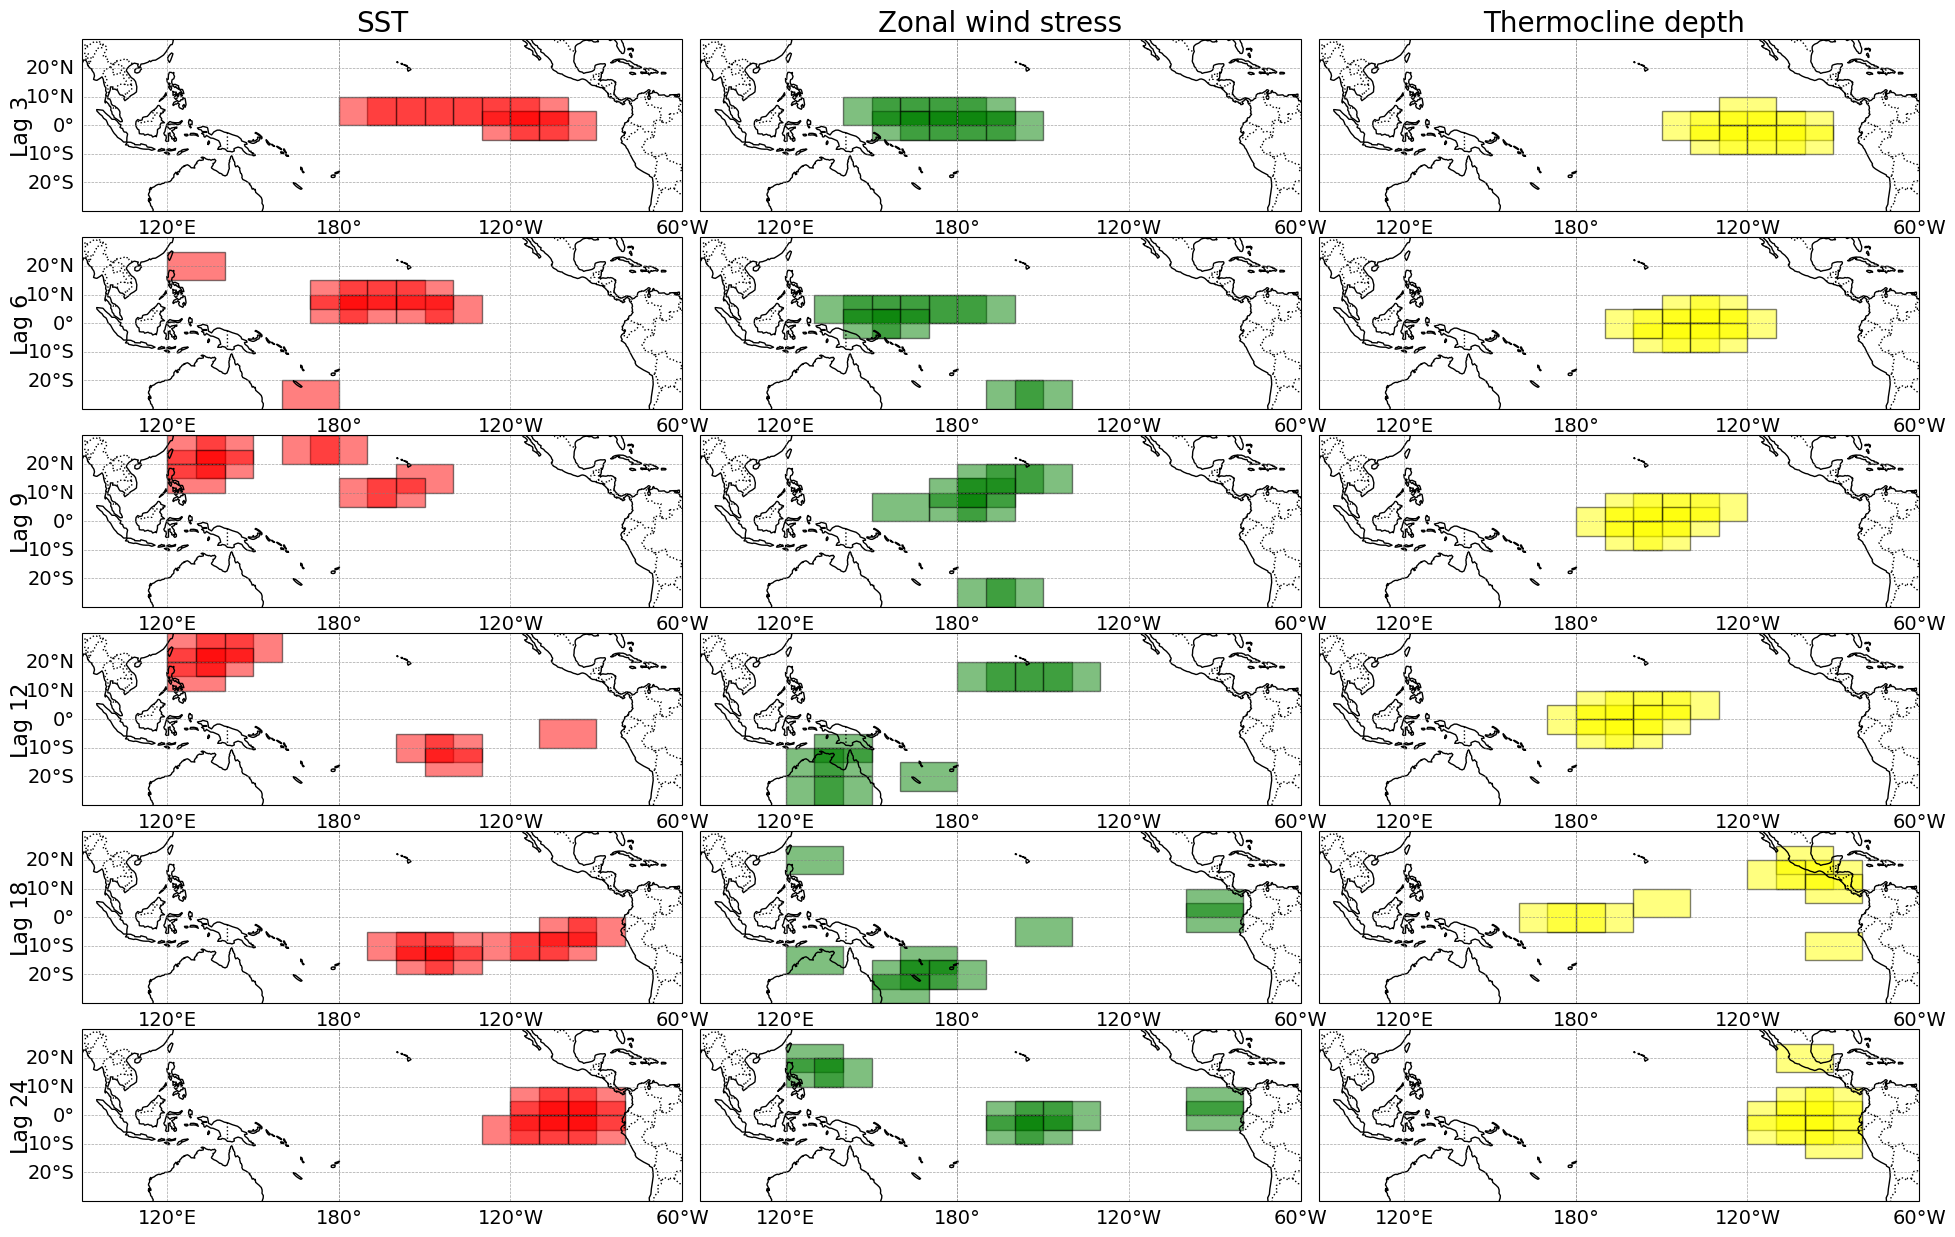

In [9]:

# Specify the lags to plot
lags_to_plot = [3, 6, 9, 12, 18, 24]

# Create a figure
fig = plt.figure(figsize=(17.5, 2.2 * len(lags_to_plot)))
gs = gridspec.GridSpec(len(lags_to_plot), 3, figure=fig, wspace=0.03, hspace=0)
plt.subplots_adjust(left=-0.1, right=0.95, top=0.95, bottom=0.05)

# Loop through each lag and create subplots for SST, WS, and Z20
for i, lag in enumerate(lags_to_plot):
    # Filter data for the current lag
    sst_data = top_10_per_lag_sst[top_10_per_lag_sst['lag'] == lag]
    ws_data = top_10_per_lag_ws[top_10_per_lag_ws['lag'] == lag]
    z20_data = top_10_per_lag_z20[top_10_per_lag_z20['lag'] == lag]

    # Variables to iterate through
    data_list = [sst_data, ws_data, z20_data]
    titles = ["SST", "Zonal wind stress", "Thermocline depth "]
    colors = ["red", "green", "yellow"]

    for j, (data, title, color) in enumerate(zip(data_list, titles, colors)):
        ax = fig.add_subplot(gs[i, j], projection=ccrs.PlateCarree(central_longitude=180))

        # Set map extent
        ax.set_extent([90, 300, -30, 30], crs=ccrs.PlateCarree())

        # Add map features
        ax.coastlines()
        ax.add_feature(cfeature.BORDERS, linestyle=':')

        # Add gridlines with labels
        gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.7, linestyle='--')
        gl.top_labels = False  # Disable top labels
        gl.right_labels = False  # Disable right labels

        # Remove x-axis labels for WS and Z20 graphs
        if j > 0:  # Applies to WS and Z20 columns only
            gl.left_labels = False
        gl.xlabel_style = {'size': 14}
        gl.ylabel_style = {'size': 14}

        # Add rectangles for each region
        for _, row in data.iterrows():
            rect = Rectangle(
                (row['lon_start'], row['lat_start']),
                row['lon_end'] - row['lon_start'],
                row['lat_end'] - row['lat_start'],
                edgecolor='black',
                facecolor=color,
                transform=ccrs.PlateCarree(),
                alpha=0.5
            )
            ax.add_patch(rect)

        # Add titles
        if i == 0:
            ax.set_title(title, fontsize=20)
        if j == 0:
            ax.text(-0.1, 0.5, f"Lag {lag}", transform=ax.transAxes, fontsize=16, rotation=90, va='center', ha='center')

# Save the figure
plt.savefig('Figures/Regions_Lags_SST_WS_Z20.pdf', bbox_inches='tight', dpi=300)
plt.show()
